In [61]:
import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms
import torch.nn as nn
from einops import rearrange
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.init as init
from torch.nn.utils import clip_grad_norm_
import torchvision

In [62]:
DATA_DIR = 'data/CIFAR10'

In [63]:
def get_cifar10_data_loader(batch_size, num_workers=4):
    """
    Get the CIFAR10 data loader
    """
    # define the transform
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # get the training and testing datasets
    train_dataset = CIFAR10(root=DATA_DIR, train=True, transform=transform, download=True)
    test_dataset = CIFAR10(root=DATA_DIR, train=False, transform=transform, download=True)
    train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])
    # get the data loaders
    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True,
                                               num_workers=num_workers, drop_last=True)
    val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True,
                                             num_workers=num_workers, drop_last=False)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False,
                                              num_workers=num_workers, drop_last=False)

    return train_loader, val_loader, test_loader

In [64]:
class Encoder(nn.Module):
    def __init__(self, num_input_channels, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, hidden_dim, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(hidden_dim, 2 * hidden_dim, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
            nn.Conv2d(2 * hidden_dim, 2 * hidden_dim, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(2 * hidden_dim, 2 * hidden_dim, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
            nn.Flatten(),
            nn.Linear(2 * hidden_dim * 4 * 4, latent_dim)
        )

    def forward(self, x):
        return self.net(x)

In [65]:
class Decoder(nn.Module):
    def __init__(self, num_output_channels, hidden_dim, latent_dim):
        super(Decoder, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 2 * hidden_dim * 4 * 4),
            nn.GELU(),
        )

        self.net = nn.Sequential(
            nn.ConvTranspose2d(2 * hidden_dim, 2*hidden_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.GELU(),
            nn.Conv2d(2 * hidden_dim, 2 * hidden_dim, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(2 * hidden_dim, hidden_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.GELU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(hidden_dim, num_output_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh() # the input is normalized to [-1, 1], so the output should also be normalized to [-1, 1]
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.fc(x)
        x = rearrange(x, 'b (c h w) -> b c h w', h=4, w=4, b=batch_size)
        return self.net(x)

In [66]:
class AutoEncoder(nn.Module):
    def __init__(self,
                 hidden_dim: int,
                 latent_dim: int,
                 num_input_channels=3
                 ):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(num_input_channels, hidden_dim, latent_dim)
        self.decoder = Decoder(num_input_channels, hidden_dim, latent_dim)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [67]:
def compute_reconstruction_loss(x, x_hat, reduction='none'):
    loss = F.mse_loss(x_hat, x, reduction=reduction)
    loss = loss.sum(dim=(1, 2, 3)).mean(dim=[0])
    # print("***** loss shape ****", loss)
    return loss

In [68]:
def save_training_state(epoch, model, optimizer, scheduler, save_path):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }
    torch.save(state, save_path)

In [69]:
def load_training_state(model, model_path, optimizer=None, scheduler=None, device='cpu'):
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    return epoch

In [70]:
def train(model, train_loader, val_loader, num_epochs=500, optimizer=None, scheduler=None, device='cpu', model_checkpoint_path=None, grad_clip = 5.0):
    model = model.to(device)

    # load_path = 'model_checkpoint.pth'
    start_epoch = 0
    if model_checkpoint_path is not None:
        start_epoch = load_training_state(model,model_checkpoint_path, optimizer=optimizer, scheduler=scheduler, device=device)
        print(start_epoch)
        print(f"Loaded model from {model_checkpoint_path} and resuming training from epoch {start_epoch + 1}.")

    for epoch in range(num_epochs):
        model.train()
        training_loss = 0
        total_samples = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            # print("min and max", data.min(), data.max())

            recon = model(data)
            loss = compute_reconstruction_loss(data, recon)
            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), grad_clip)
            # for name, param in model.named_parameters():
            #     if param.grad is not None:
            #         print(name, param.grad.norm())
            #
            optimizer.step()
            training_loss += loss.item()
            total_samples += data.shape[0]

        training_loss /= len(train_loader)
        print(f'Epoch: {epoch + start_epoch + 1}, Training Loss: {training_loss:.4f}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_idx, (data, _) in enumerate(val_loader):
                data = data.to(device)
                recon = model(data)
                loss = compute_reconstruction_loss(data, recon)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f'Epoch: {epoch + start_epoch + 1}, Val Loss: {val_loss:.4f}')
        scheduler.step(val_loss)
    # print("===== epoch is =====", epoch)
    save_path = f'model_checkpoint.pth'
    save_training_state(epoch, model, optimizer, scheduler, save_path)
    return model

In [76]:
def plot_reconstructions(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        recon = model(data)
        recon = recon.cpu().numpy()
        data = data.cpu().numpy()

    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        axes[0, i].imshow(data[i].transpose(1, 2, 0))
        axes[0, i].set_title("Original")  # set title for the top row
        axes[1, i].imshow(recon[i].transpose(1, 2, 0))
        axes[1, i].set_title("Reconstructed")  # set title for the bottom row

    # Adjust the subplot layout, because the logit one may take more space
    # than usual, due to y-tick labels like "1 - 10^{-3}"
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
    plt.show()


In [74]:
batch_size = 256
num_epochs = 500
learning_rate = 1e-3
latent_dim = 256
hidden_dim = 32
train_loader, val_loader, test_loader = get_cifar10_data_loader(batch_size)
model = AutoEncoder(hidden_dim=hidden_dim, latent_dim=latent_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min',
                                                       factor=0.2,
                                                       patience=20,
                                                       min_lr=5e-5)


Files already downloaded and verified
Files already downloaded and verified


### Train model

In [75]:
model = train(model, train_loader, val_loader, optimizer=optimizer, scheduler=scheduler,  device=device)

Epoch: 1, Training Loss: 337.5332
Epoch: 1, Val Loss: 204.5210
Epoch: 2, Training Loss: 171.2817
Epoch: 2, Val Loss: 133.5636
Epoch: 3, Training Loss: 123.0135
Epoch: 3, Val Loss: 118.1164
Epoch: 4, Training Loss: 107.9338
Epoch: 4, Val Loss: 101.2367
Epoch: 5, Training Loss: 94.5246
Epoch: 5, Val Loss: 86.5557
Epoch: 6, Training Loss: 82.1286
Epoch: 6, Val Loss: 76.6649
Epoch: 7, Training Loss: 73.8718
Epoch: 7, Val Loss: 69.5386
Epoch: 8, Training Loss: 68.0401
Epoch: 8, Val Loss: 64.8720
Epoch: 9, Training Loss: 63.1794
Epoch: 9, Val Loss: 60.1145
Epoch: 10, Training Loss: 59.0410
Epoch: 10, Val Loss: 56.9307
Epoch: 11, Training Loss: 56.1688
Epoch: 11, Val Loss: 53.6916
Epoch: 12, Training Loss: 53.4010
Epoch: 12, Val Loss: 52.1282
Epoch: 13, Training Loss: 50.6561
Epoch: 13, Val Loss: 50.0262
Epoch: 14, Training Loss: 48.3908
Epoch: 14, Val Loss: 46.7218
Epoch: 15, Training Loss: 46.3731
Epoch: 15, Val Loss: 45.2722
Epoch: 16, Training Loss: 44.5196
Epoch: 16, Val Loss: 44.1448
Ep

### Load model from saved checkpoint

In [81]:
model_from_checkpoint = AutoEncoder(hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
epoch = load_training_state(model_from_checkpoint, 'model_checkpoint.pth', device=device)
print(f"Loaded model from epoch {epoch + 1}.")

Loaded model from epoch 500.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

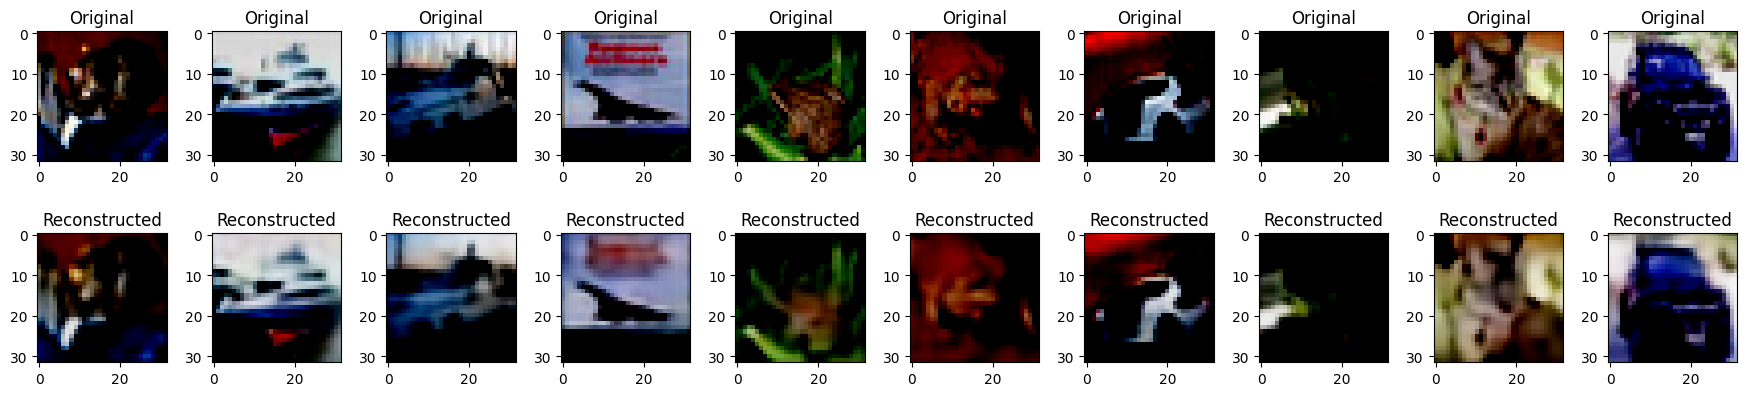

In [82]:
plot_reconstructions(model_from_checkpoint, test_loader, device)